# Advanced Econometrics (JEM217)– Home Assignment 2 (WS 2025)



**Authors: Sebastian Pasz, Vojtěch Dohnal, Tomáš Gabriel**

**AI Usage**

ChatGPT-5 was used during the preparation of this assignment **solely for grammatical editing and minor code optimization**.  
Any sections where AI-assisted code optimization was applied are explicitly indicated within the notebook.

## Initial Preparation

In this section, we install and load all required R packages necessary for data simulation, estimation, and visualization.  
We also set a fixed random seed (`set.seed(123)`) to ensure that all simulated results are fully reproducible.


In [1]:

req_pkgs <- c("ggplot2","dplyr","quantreg","lmtest","sandwich","car","stargazer","knitr","glm2","gmm","msm")
for (p in req_pkgs) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, repos = "https://cloud.r-project.org")
  }
}
library(ggplot2)
library(dplyr)
library(quantreg)
library(lmtest)
library(sandwich)
library(car)
library(stargazer)
library(knitr)
library(glm2)
library(gmm)
library(msm)


set.seed(123) 


Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'quantreg' was built under R version 4.4.3"
Loading required package: SparseM

Warning message:
"package 'SparseM' was built under R version 4.4.3"
Warning message:
"package 'lmtest' was built under R version 4.4.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.4.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'sandwich' was built under R version 4.4.3"
Warning message:
"package 'car' was built under R version 4.4.3"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 4.4.3"

Attaching package: 'car'


The following

## Problem 1 (a)
Simulating the $e_t$ process. And checking length of all 3 variables. We can see that all have length 1000.



In [2]:
T_full <- 1002                 # total length for e_t
e      <- rnorm(T_full, 0, 1)  # e_t ~ N(0,1)

e_t   <- e[3:T_full]           # t = 3..1002  -> length 1000
e_t_1 <- e[2:(T_full-1)]       # t-1
e_t_2 <- e[1:(T_full-2)]       # t-2

print(paste0(
  "Length e_t: ", length(e_t),
  ", t-1: ", length(e_t_1),
  ", t-2: ", length(e_t_2)
))

mu_true   <- 0
theta1_true <- 0.75
theta2_true <- 0.5
sigma2_true <- 1  # variance of e_t in DGP

y <- mu_true + e_t + theta1_true * e_t_1 + theta2_true * e_t_2
T <- length(y)
summary(y)

[1] "Length e_t: 1000, t-1: 1000, t-2: 1000"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-3.52537 -0.89595  0.06423  0.03472  0.92814  3.91749 

## (b)
Cheching ACF and PACF to see if the model is indeed MA(2)
From ACF we can see that the process looks MA(2) - because the first two lags values are very high (far from zero) and for lags <2 values are close to zero indicating that the proces is not of higher order.

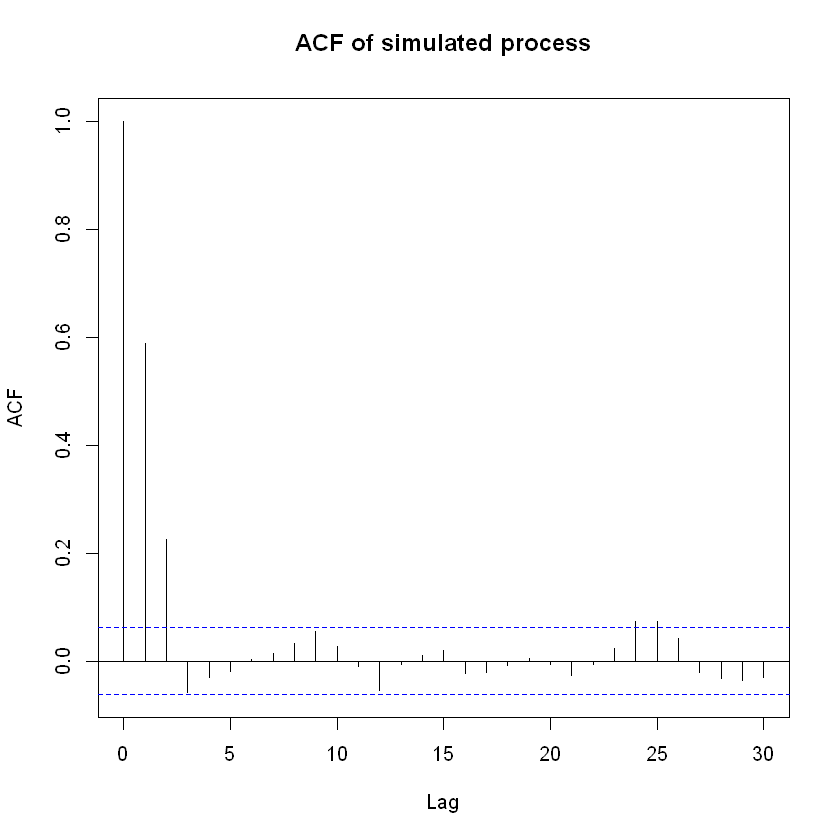

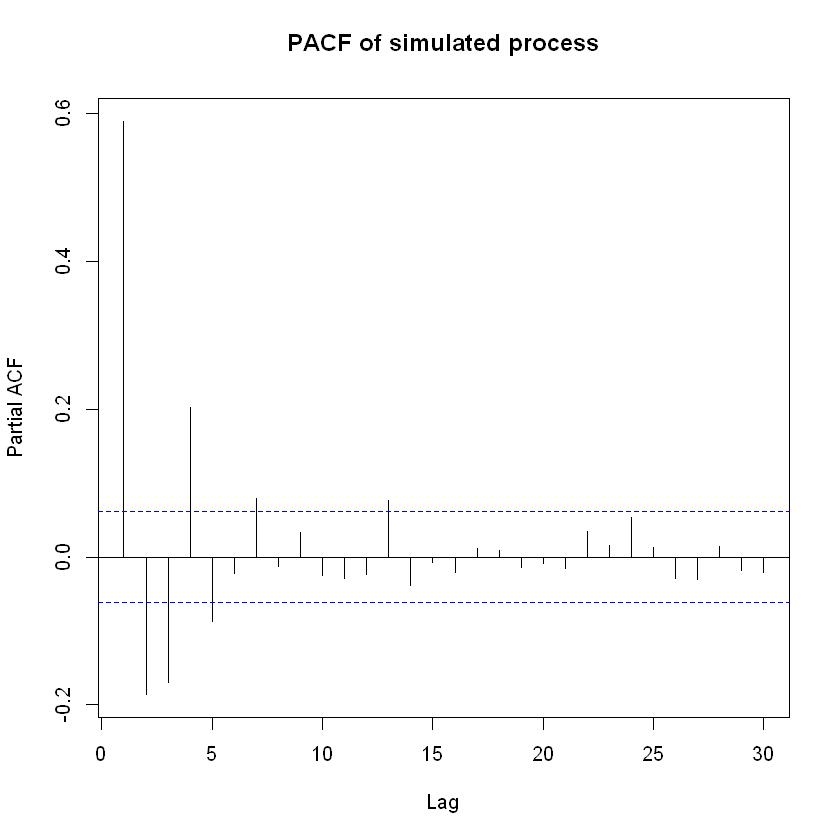

In [3]:
par(bg = "white")
acf(y, main = "ACF of simulated process")
pacf(y, main = "PACF of simulated process")

## (c)

Obtaining the moment conditions and creating a function to use them.


In [4]:
max_lag <- 4

y_lag0 <- y[(1+max_lag):T]
y_lag1 <- y[(1+max_lag-1):(T-1)]
y_lag2 <- y[(1+max_lag-2):(T-2)]
y_lag3 <- y[(1+max_lag-3):(T-3)]
y_lag4 <- y[(1+max_lag-4):(T-4)]

stopifnot(
  length(y_lag0) == length(y_lag1),
  length(y_lag0) == length(y_lag2),
  length(y_lag0) == length(y_lag3),
  length(y_lag0) == length(y_lag4)
)


data_gmm <- data.frame(
  y  = y_lag0,
  y1 = y_lag1,
  y2 = y_lag2,
  y3 = y_lag3,
  y4 = y_lag4
)


ma2_moments <- function(theta, data) {
  mu   <- theta[1]
  th1  <- theta[2]
  th2  <- theta[3]
  sig2 <- theta[4]

  yt <- data$y
  y1 <- data$y1
  y2 <- data$y2
  y3 <- data$y3
  y4 <- data$y4

  u  <- yt - mu
  u1 <- y1 - mu
  u2 <- y2 - mu
  u3 <- y3 - mu
  u4 <- y4 - mu

  gamma0 <- (1 + th1^2 + th2^2) * sig2
  gamma1 <- (th1 + th1 * th2)  * sig2
  gamma2 <- th2 * sig2
  gamma3 <- 0
  gamma4 <- 0

  m1 <- u                         # E[u_t] = 0
  m2 <- u^2    - gamma0           # Var
  m3 <- u*u1   - gamma1           # Cov lag 1
  m4 <- u*u2   - gamma2           # Cov lag 2
  m5 <- u*u3   - gamma3           # Cov lag 3
  m6 <- u*u4   - gamma4           # Cov lag 4

  cbind(m1, m2, m3, m4, m5, m6)
}


theta_start <- c(
  mu   = mean(y),
  th1  = 0.3,
  th2  = 0.2,
  sig2 = var(y) / 3
)

head(ma2_moments(theta_start, data_gmm))
summary(as.vector(ma2_moments(theta_start, data_gmm)))


m1,m2,m3,m4,m5,m6
1.77714271,2.5186330,3.01742616,1.53386433,1.93661421,1.90353535
-0.09655769,-0.6302798,-0.37536420,-0.28822158,-0.08949035,-0.10522228
-1.43990678,1.4337283,-0.06473333,-2.67212395,-2.60993022,-1.33451580
-1.62804833,2.0109381,2.14047043,0.04399648,-2.89327422,-2.95094974
0.51169279,-0.3777737,-1.03682799,-0.84999403,-0.04940787,0.90935111
1.02032808,0.4014662,0.31832712,-1.77434755,-1.46917733,-0.09852053


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-8.0144 -0.5349  0.0406  0.3272  0.9376 14.4363 

## (d)

We estimate the MA(2) model by GMM under two configurations:

1. One-step GMM with **identity weighting matrix** (`wmatrix = "ident"`).
2. Two-step GMM with **optimal weighting matrix** (`wmatrix = "optimal"`).

The true DGP parameters are:
$
\mu = 0,\quad \theta_1 = 0.75,\quad \theta_2 = 0.5,\quad \sigma^2 = 1.
$

---

#### One-step GMM with identity weighting matrix


- $\mu$ is **not statistically significant** (p ≫ 0.05), which is consistent with the true mean of zero.
- $\theta_1$ and $\theta_2$ are **highly significant**, confirming the presence of MA(2) dynamics. $\theta_1$ is close to the true 0.75; $\theta_2$ is somewhat biased downward relative to 0.5.
- $\sigma^2$ is significantly different from zero and close to the true variance of 1.

J-test for overidentifying restrictions:

- J = 15.15, df = 2, p = 0.000513  
- We **reject** $H_0: E[g(\theta)] = 0$.  
  This indicates that, with the identity weighting matrix, the set of moment conditions is not jointly consistent with the data. In other words, the model plus chosen moments are rejected under this weighting scheme.

---

#### Two-step GMM with optimal weighting matrix

- $\mu$ remains **insignificant**, again consistent with a zero-mean process.
- $\theta_1$ and $\theta_2$ are **very precisely estimated** and now lie very close to their true values (0.75 and 0.5). Standard errors are lower than under the identity weighting, reflecting the efficiency gains of optimal GMM.
- $\sigma^2$ is almost exactly 1, matching the true innovation variance.

J-test for overidentifying restrictions:

- J = 2.45, df = 2, p = 0.293  
- We **do not reject** $H_0: E[g(\theta)] = 0$.  
  Under the optimal weighting matrix, the overidentifying restrictions are satisfied; the MA(2) specification and the chosen set of moments are jointly consistent with the data.


In [5]:


gmm_id <- gmm(
  g        = ma2_moments,
  x        = data_gmm,
  t0       = theta_start,
  wmatrix  = "ident",     
  type     = "twoStep"     
)

summary(gmm_id)
specTest(gmm_id)           # J-test


gmm_opt <- gmm(
  g        = ma2_moments,
  x        = data_gmm,
  t0       = coef(gmm_id), 
  wmatrix  = "optimal",
  type     = "twoStep"     
)

summary(gmm_opt)
specTest(gmm_opt)


Call:
gmm(g = ma2_moments, x = data_gmm, t0 = theta_start, type = "twoStep", 
    wmatrix = "ident")


Method:  One step GMM with W = identity 

Kernel:  Quadratic Spectral

Coefficients:
      Estimate    Std. Error  t value     Pr(>|t|)  
mu    2.7810e-02  8.5086e-02  3.2685e-01  7.4378e-01
th1   7.0166e-01  3.6526e-02  1.9210e+01  3.0723e-82
th2   3.6612e-01  7.8457e-02  4.6665e+00  3.0630e-06
sig2  1.0433e+00  5.0127e-02  2.0812e+01  3.3498e-96

J-Test: degrees of freedom is 2 
                J-test      P-value   
Test E(g)=0:    1.5149e+01  5.1338e-04

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  227 
Gradian eval. =  NA 


 ##  J-Test: degrees of freedom is 2  ## 

                J-test      P-value   
Test E(g)=0:    1.5149e+01  5.1338e-04



Call:
gmm(g = ma2_moments, x = data_gmm, t0 = coef(gmm_id), type = "twoStep", 
    wmatrix = "optimal")


Method:  twoStep 

Kernel:  Quadratic Spectral(with bw =  3.01264 )

Coefficients:
      Estimate     Std. Error   t value      Pr(>|t|)   
mu     2.3244e-02   8.5012e-02   2.7342e-01   7.8453e-01
th1    7.3398e-01   3.2605e-02   2.2511e+01  3.2204e-112
th2    4.8504e-01   4.0229e-02   1.2057e+01   1.7814e-33
sig2   9.9261e-01   4.7231e-02   2.1016e+01   4.6526e-98

J-Test: degrees of freedom is 2 
                J-test   P-value
Test E(g)=0:    2.45317  0.29329

Initial values of the coefficients
        mu        th1        th2       sig2 
0.02772721 0.70168832 0.36612202 1.04318868 

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  251 
Gradian eval. =  NA 


 ##  J-Test: degrees of freedom is 2  ## 

                J-test   P-value
Test E(g)=0:    2.45317  0.29329


## Problem 2: Bootstrap

I, Tomáš Gabriel, used ChatGPT 5.1 during the preparation of this output for grammatical correction, refinement of markdown explanations, and minor code optimization (such as confirming correct syntax or checking the correctness of specific commands).
No parts of the assignment were fully generated by the tool; all statistical procedures, analysis steps, and code structure were written and implemented by me.

Assume a random sample from an exponential distribution, $X \sim \exp(\lambda)$.

### a) & b)

We generate 200 observations from an exponential distribution with rate parameter $\lambda = 2$.  
To verify that the generated sample behaves consistently with the assumed distribution, we compare the empirical sample moments to the theoretical ones.

The theoretical mean and variance of an exponential distribution with rate $\lambda$ are:
$$
\mathbb{E}[X] = \frac{1}{\lambda}, 
\qquad 
\mathrm{Var}(X) = \frac{1}{\lambda^{2}}.
$$

For $\lambda = 2$, this gives:
$$
\mathbb{E}[X] = 0.5, \qquad \mathrm{Var}(X) = 0.25.
$$

Using the simulated data, we obtain:

- **Sample mean:** 0.5036  
- **Sample variance:** 0.2336

These values are close to the theoretical quantities.  
Given that the sample size is finite ($n = 200$), small deviations from the theoretical values are expected. With larger samples, the law of large numbers ensures that the sample mean and variance would converge further toward 0.5 and 0.25, respectively.


In [6]:
set.seed(123)

# Parameters
n <- 200
lambda <- 2

# Generate data
x_exp <- rexp(n, rate = lambda)

# Sample vs Theoretical Statistics
sample_mean <- mean(x_exp)
sample_var  <- var(x_exp)

theo_mean <- 1 / lambda
theo_var  <- 1 / lambda^2

# Results
print(c(Theoretical_Mean = theo_mean, Sample_Mean = sample_mean))
print(c(Theoretical_Var  = theo_var,  Sample_Var  = sample_var))

Theoretical_Mean      Sample_Mean 
       0.5000000        0.5036166 
Theoretical_Var      Sample_Var 
      0.2500000       0.2335522 


### c) Graphical analysis

The histogram, kernel density estimate, and theoretical exponential density show that the kernel estimate follows the theoretical curve closely. This suggests that the simulated sample behaves consistently with an $\text{Exp}(\lambda = 2)$ distribution.

In the exponential Q–Q plot, most points lie on or very close to the 45° reference line. Small deviations appear in the upper tail, which is expected for a finite sample from a right-skewed distribution. Overall, there is no systematic departure from the theoretical exponential distribution.


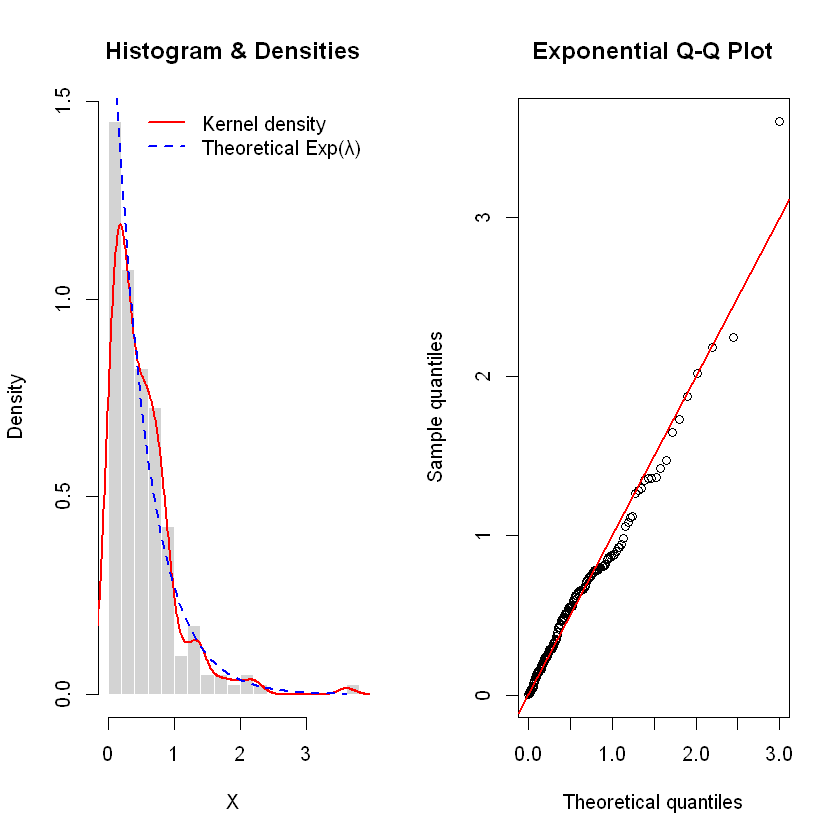

In [7]:
# Plot histogram + densities and exponential Q-Q plot
par(mfrow = c(1, 2))
par(bg = "white")
# Histogram with kernel and theoretical density
hist(x_exp, prob = TRUE, breaks = 15,
     main = "Histogram & Densities",
     xlab = "X", col = "lightgray", border = "white")

# Kernel density estimate
lines(density(x_exp), col = "red", lwd = 2)

# Theoretical exponential density
curve(dexp(x, rate = lambda),
      from = 0, to = max(x_exp),
      add = TRUE, col = "blue", lwd = 2, lty = 2)

legend("topright",
       legend = c("Kernel density", "Theoretical Exp(λ)"),
       col = c("red", "blue"), lwd = 2, lty = c(1, 2), bty = "n")

# Exponential Q-Q plot: sample vs theoretical quantiles
theoretical_quantiles <- qexp(ppoints(n), rate = lambda)

qqplot(theoretical_quantiles, x_exp,
       main = "Exponential Q-Q Plot",
       xlab = "Theoretical quantiles",
       ylab = "Sample quantiles")

abline(0, 1, col = "red", lwd = 2)


### d) Brute-force bootstrap

We use a non-parametric bootstrap to approximate the sampling distribution of the sample mean.  
The procedure resamples the original data with replacement ($B = 100\,000$) times.  
For each bootstrap sample, we compute the mean and then use these bootstrap estimates to obtain:

- the bootstrap estimate of the mean  
- the bootstrap standard error  
- the estimated bias  
- the bias-reduced estimate of the mean

The bias-reduced estimator is defined as:

$$
\hat{\theta}_{BR}
= \hat{\theta} - \widehat{\text{Bias}}
= \hat{\theta} - (\bar{\theta}^{\ast} - \hat{\theta})
= 2\hat{\theta} - \bar{\theta}^{\ast},
$$

where $\bar{\theta}^{\ast}$ is the average of the bootstrap estimates.

The bootstrap results confirm that the sample mean has essentially no bias.  
The bootstrap standard error of roughly 0.034 reflects the expected sampling variability of the mean for a sample of size $n = 200$.  
Overall, the bootstrap distribution is centered very close to the original estimate, which is consistent with the properties of the exponential distribution.


In [8]:
B <- 100000                # bootstrap replications
boot_means <- numeric(B)   # vector to store bootstrap means

# Brute-force bootstrap loop
for (b in 1:B) {
  boot_sample <- sample(x_exp, size = n, replace = TRUE)
  boot_means[b] <- mean(boot_sample)
}

# Bootstrap summary statistics
boot_mean_est <- mean(boot_means)
boot_se       <- sd(boot_means)
boot_bias     <- boot_mean_est - sample_mean
bias_reduced  <- 2 * sample_mean - boot_mean_est

# Results
boot_mean_est
boot_se
boot_bias
bias_reduced

[1] 0.5035695

[1] 0.03399261

[1] -4.705782e-05

[1] 0.5036637

### e) Bootstrap using the `boot` package

We repeat the bootstrap procedure using the `boot` package.  
The function `mean.boot` computes the sample mean for each resampled index set, and the `boot()` function performs $100{,}000$ bootstrap replications.

The bootstrap estimate, bias, and standard error are almost identical to the results obtained via the brute-force bootstrap in part d), confirming consistency between both approaches.


In [9]:
library(boot)

# Mean function for bootstrap
mean.boot <- function(data, idx) {
  mean(data[idx])
}

# Bootstrap with 100 000 replications
boot.out <- boot(data = x_exp, statistic = mean.boot, R = 100000)

boot.out


Attaching package: 'boot'


The following object is masked from 'package:msm':

    cav


The following object is masked from 'package:car':

    logit





ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = x_exp, statistic = mean.boot, R = 1e+05)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.5036166 4.068777e-05  0.03420744

### f) Bootstrap confidence intervals

Using the object `boot.out`, we compute four types of 95% bootstrap confidence intervals for the
mean: Normal, Basic, Percentile, and BCa. The resulting intervals are:

- Normal:      (0.4369, 0.5702)
- Basic:       (0.4346, 0.5679)
- Percentile:  (0.4394, 0.5726)
- BCa:         (0.4439, 0.5785)

All four intervals are centered around the sample mean (≈ 0.504) and are numerically very close.  
Their endpoints differ by at most about 0.01, which indicates that the bootstrap distribution of the
sample mean is regular and nearly symmetric.

The bootstrap histogram shows a bell-shaped distribution centered near the original estimate. Even
though the underlying exponential distribution is skewed, for a sample size of $n = 200$ the Central
Limit Theorem implies that the sampling distribution of the **mean** is close to normal. This matches
what we observe in the bootstrap output: the distribution has only mild skewness, and the different
bootstrap intervals are therefore quite similar.
 
Because the bootstrap distribution is nearly symmetric, all four interval types provide very similar
results. However, the **BCa interval** is the most appropriate choice in this setting. BCa adjusts for
both bias and skewness in the bootstrap distribution, whereas the Normal and Basic intervals rely on
stronger symmetry assumptions. The Percentile interval also performs well, but BCa is the most robust
and is formally the preferred method. In this particular case the differences are small, but BCa
remains theoretically superior.


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 100000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot.out, conf = 0.95, type = c("norm", "basic", 
    "perc", "bca"))

Intervals : 
Level      Normal              Basic         
95%   ( 0.4365,  0.5706 )   ( 0.4336,  0.5677 )  

Level     Percentile            BCa          
95%   ( 0.4395,  0.5736 )   ( 0.4444,  0.5800 )  
Calculations and Intervals on Original Scale

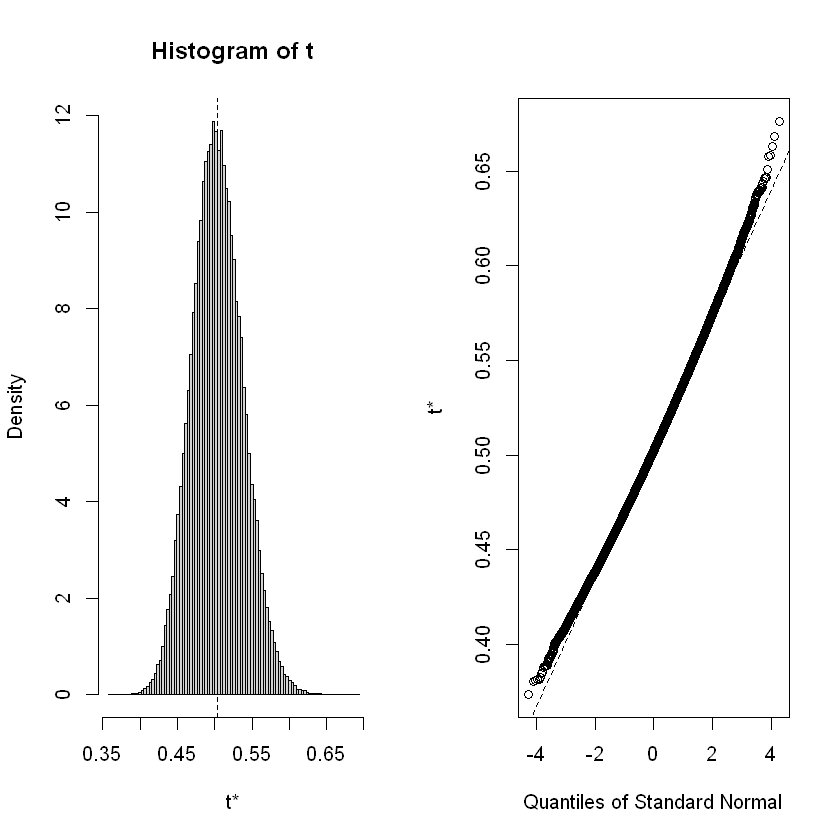

In [10]:
par(bg = "white")
# 95% confidence intervals (Normal, Basic, Percentile, BCa)
boot.ci(boot.out, conf = 0.95, type = c("norm", "basic", "perc", "bca"))
par(bg = "white")
# Plot distribution
plot(boot.out)


## Problem 3: Endogeneity
### Data Simulation


In [11]:
library(AER)
library(systemfit)

nobs = 300

# Generating the random variables according to the instructions 

# instruments
z1 = rnorm(nobs,2,3)
z2 = rnorm(nobs,2,1.5)
z3 = rnorm(nobs,0,2)
z4 = rnorm(nobs,1.8,2.5)    

# generate the error
e1 = rnorm(nobs,0,1.5)
e2 = rnorm(nobs,0,1.5)
e3 = rnorm(nobs,0,1.5)

# create the explanatory variables
x1 = 0.3 * z1 - z2 + 0.9 * z4 + 0.75 * e1
x2 = 0.75 * z2 + 0.75 * e2
x3 = rnorm(nobs,0,1)

# create the dependent variable
y = 1 + 2.5 * x1 - x2 + 0.45 * x3 + e3

Warning message:
"package 'AER' was built under R version 4.4.3"


Loading required package: survival


Attaching package: 'survival'


The following object is masked from 'package:boot':

    aml


The following object is masked from 'package:glm2':

    heart


The following object is masked from 'package:quantreg':

    untangle.specials


Warning message:
"package 'systemfit' was built under R version 4.4.3"
Loading required package: Matrix


Attaching package: 'Matrix'


The following object is masked from 'package:SparseM':

    det



Please cite the 'systemfit' package as:
Arne Henningsen and Jeff D. Hamann (2007). systemfit: A Package for Estimating Systems of Simultaneous Equations in R. Journal of Statistical Software 23(4), 1-40. http://www.jstatsoft.org/v23/i04/.

If you have questions, suggestions, or comments regarding the 'systemfit' package, please use a forum or 'tracker' at systemfit's R-Forge site:
https://r-forge.r-project.org/projects/systemfit/



### a)

<!-- The endogeneity problem in our model comes from the fact that the variable x1 in our model is correlated with x2 through z2 and since x2 is not controled for in the model i.e. the error term contains it, therefore we have correlated error ter with an explanatory variable. The important correlations could be seen in the table below. The difference between x1 and x2: - x1: depends on 4 other random variables out of which one also determines the variable present in the error -> x1 is an endogenous variable in our model - x3: is randomly drawn from the standard normal distribution and therefore is completely independent of all other random vars -> exogenous explanatory variable We expect the OLS estimation to be biased because of the above described endogeneity -->

The endogeneity problem in our model arises because the regressor x1 is correlated with x2 through their shared dependence on z2. Since x2 is omitted from the estimated model, it becomes part of the error term. As a result, the error term is correlated with an explanatory variable (x1), which violates one of the key OLS assumptions. This can also be observed in the correlation table below.

Regarding the difference between x1 and x3:

x1 depends on four other random variables, one of which (z2) also helps determine x2, a variable contained in the error term. Therefore, x1 is an endogenous regressor in our model.

x3 is drawn independently from a standard normal distribution and is therefore completely unrelated to all other random variables. This makes x3 an exogenous explanatory variable.

Because of this endogeneity, we expect the OLS estimate of the coefficient on x1 to be biased.

In [12]:
df <- data.frame(z1,z2,z3,z4,e1,e2,e3,x1,x2,x3,y)

# Upper correlation matrix
cor_mat <- round(cor(df), 4)
upper_mat <- cor_mat
upper_mat[lower.tri(upper_mat)] <- NA
upper_mat

,z1,z2,z3,z4,e1,e2,e3,x1,x2,x3,y
z1,1,-0.0401,-0.0541,0.1028,0.0957,0.0591,0.0395,0.4169,0.0134,-0.0862,0.3737
z2,NA,1.0000,0.0544,-0.0205,-0.0267,0.0126,0.0120,-0.5227,0.7114,-0.0786,-0.6047
z3,NA,NA,1.0000,-0.0594,0.0076,-0.1238,0.0307,-0.0822,-0.0488,0.0318,-0.0579
z4,NA,NA,NA,1.0000,-0.1025,-0.0787,-0.0306,0.7209,-0.0697,-0.0437,0.6530
e1,NA,NA,NA,NA,1.0000,0.0238,-0.0103,0.3123,-0.0021,0.0756,0.2833
e2,NA,NA,NA,NA,NA,1.0000,-0.0399,-0.0371,0.7117,0.0100,-0.1723
e3,NA,NA,NA,NA,NA,NA,1.0000,-0.0198,-0.0197,-0.0426,0.1484
x1,NA,NA,NA,NA,NA,NA,NA,1.0000,-0.3933,0.0080,0.9687
x2,NA,NA,NA,NA,NA,NA,NA,NA,1.0000,-0.0482,-0.5459
x3,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.0000,0.0643


### b)

In [13]:
ols <- lm(y ~ x1 + x3, data = df)
summary(ols)


Call:
lm(formula = y ~ x1 + x3, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.1283 -1.3057  0.1446  1.2188  5.4722 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.47205    0.11978  -3.941 0.000101 ***
x1           2.69540    0.03903  69.062  < 2e-16 ***
x3           0.46150    0.11448   4.031 7.06e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.074 on 297 degrees of freedom
Multiple R-squared:  0.9416,	Adjusted R-squared:  0.9412 
F-statistic:  2395 on 2 and 297 DF,  p-value: < 2.2e-16


<!--From the results we can validate our previous answer. The beta1 coefficient is significantly biased up due to the endogeneity. We can also indicate large impresicion present within the intercept. The suprising result is that while the value of the beta3 is close to the real value, the standard error is really high which is unexpected. According to the adjusted R2 the model explains approximately 93% of the variation of the dependent variable. -->
Based on the estimation results, we can validate our earlier conclusion about endogeneity. The coefficient β₁ is clearly biased upward, which is consistent with the endogeneity problem discussed previously. We can also observe substantial imprecision in the estimate of the intercept. A surprising finding is that although the estimated value of β₃ is close to the true value, its standard error is very large, which is unexpected. According to the adjusted R², the model explains approximately 93% of the variation in the dependent variable.

### c)

<!--The 'goodness' of an instrument is based on following two criteria:
- Relevance: the instrument has to reflect the desired relationship and therefore Cov(x,z) cannot be zero, in fact the higher the better 
- Exogeneity: since we are trying to deal with endogeneity, the instrument has to be exogenous Cov(e, z) has to be zero or at least close to zero. 

The instrument candidates: 
- z1 and z4: these two satisfy the above conditions well judging form the correlation matrix as well as the equations in the intructions. Both are present in the x1 eq i.e. they are relevant, and are not present in the x2 eq meaning they are exogenous.
-z3: this canditate seems to be irrelevant for our case because it is not present in the x1 eq, therefore eventhough it satisfies the exogeneity condition, we can rule it out 
-z2: this variable causes the endogeneity problem therefore while relevant (is present in the x1 eq), we definitely have to rule this one out, because that is the source of out problem 

The results of the relevance test could be seen below. The test verified that the insturments are relevent, since the null hypotheses was rejected. These results are are in line with our expectation based on the equations from the instructions. -->
The quality of an instrument is determined by two key conditions:

Relevance: the instrument must be correlated with the endogenous regressor, so Cov(x, z) ≠ 0. In practice, the stronger this correlation, the better.

Exogeneity: the instrument must be uncorrelated with the structural error term. Thus Cov(e, z) = 0, or at least very close to zero.

Assessment of the instrument candidates:

z1 and z4:
These variables satisfy both relevance and exogeneity based on the correlation matrix and the model equations. Both enter the equation for x₁, making them relevant, and neither appears in the x₂ equation, so they are exogenous.

z3:
This candidate appears to be irrelevant because it does not enter the equation for x₁. Even though it satisfies exogeneity, it cannot be used since it does not explain x₁.

z2:
This variable is the source of the endogeneity problem. While it is relevant (since it appears in x₁), we must rule it out because it also enters x₂ and therefore violates exogeneity.

The results of the relevance test are shown below. The test confirms that the instruments are relevant, since the null hypothesis was rejected. These statistical findings are consistent with our expectations based on the model equations.

In [14]:
IV_rel_test <- lm(x1 ~ z1 + z4 + x3, data = df)
summary(IV_rel_test)

linearHypothesis(IV_rel_test, c("z1 = 0", "z4 = 0"))


Call:
lm(formula = x1 ~ z1 + z4 + x3, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8752 -1.2254  0.0922  1.3207  5.0126 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.05870    0.14342 -14.355   <2e-16 ***
z1           0.36333    0.03614  10.054   <2e-16 ***
z4           0.86400    0.04388  19.690   <2e-16 ***
x3           0.20068    0.10229   1.962   0.0507 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.845 on 296 degrees of freedom
Multiple R-squared:  0.6432,	Adjusted R-squared:  0.6395 
F-statistic: 177.8 on 3 and 296 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,298,2824.329,NA,NA,NA,NA
2,296,1007.923,2,1816.406,266.7151,5.912399e-67


### d)

In [15]:
IV_reg = ivreg(y ~ x1 + x3 | z4 + x3, data = df)
summary(IV_reg)

twoSLS = ivreg(y ~ x1 + x3 | x3 + z1 + z4, data = df)
summary(twoSLS)


Call:
ivreg(formula = y ~ x1 + x3 | z4 + x3, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-7.197014 -1.290226 -0.004792  1.355696  5.476863 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.46183    0.12332  -3.745 0.000217 ***
x1           2.53109    0.05565  45.485  < 2e-16 ***
x3           0.46537    0.11785   3.949 9.82e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.135 on 297 degrees of freedom
Multiple R-Squared: 0.9381,	Adjusted R-squared: 0.9377 
Wald test:  1044 on 2 and 297 DF,  p-value: < 2.2e-16 



Call:
ivreg(formula = y ~ x1 + x3 | x3 + z1 + z4, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-7.197321 -1.289947 -0.004956  1.359650  5.480409 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.46179    0.12334  -3.744 0.000218 ***
x1           2.53036    0.05011  50.495  < 2e-16 ***
x3           0.46539    0.11788   3.948 9.85e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.136 on 297 degrees of freedom
Multiple R-Squared: 0.9381,	Adjusted R-squared: 0.9377 
Wald test:  1285 on 2 and 297 DF,  p-value: < 2.2e-16 


<!--Based on the previous point and the correlation matrix we have chosen the z4 variable as our instrument.
From the results of the IV and 2SLS regressions, we can see that all the coefficients reported by 2SLS are closer to the true values including the coefficient and also the standard errors are lower for all of the obtained coefficients. 
This result is not very surprising, since in the 2SLS we also include the additional z1 variable which is also a relevant instrument which was just not chosen in the previous step. -->

Based on the previous analysis and the correlation matrix, we selected z4 as our instrument.
From the IV and 2SLS regression results, we observe that all coefficients obtained from the 2SLS estimation are closer to the true parameter values. In addition, the standard errors are lower for all estimated coefficients.

This outcome is not surprising, since the 2SLS procedure uses an additional instrument, z1, which is also relevant but was not chosen in the single-instrument IV regression. Including this extra valid instrument naturally leads to more precise estimates.

### e)

In [16]:
ols_model   = systemfit(y ~ x1 + x3, data = df, method = "OLS")
iv_model    = systemfit(y ~ x1 + x3, data = df, method = "2SLS", inst = ~ x3 + z1 + z4)

hausman.systemfit(iv_model, ols_model)


	Hausman specification test for consistency of the 3SLS estimation

data:  df
Hausman = 27.575, df = 3, p-value = 4.46e-06


The Hausmann test proves our endogeneity concerns. The null hypothesis of this test, that is, the exogeneity, is strongly rejected at all conventional levels. This result supports the conclusion that OLS is inconsistent in this setting and that an IV/2SLS approach is necessary.

### f)

In [17]:
nobs = 30000

# Generating the random variables according to the instructions 

# instruments
z1 = rnorm(nobs,2,3)
z2 = rnorm(nobs,2,1.5)
z3 = rnorm(nobs,0,2)
z4 = rnorm(nobs,1.8,2.5)    

# generate the error
e1 = rnorm(nobs,0,1.5)
e2 = rnorm(nobs,0,1.5)
e3 = rnorm(nobs,0,1.5)

# create the endogenous variables
x1 = 0.3 * z1 - z2 + 0.9 * z4 + 0.75 * e1
x2 = 0.75 * z2 + 0.75 * e2
x3 = rnorm(nobs,0,1)

# create the dependent variable
y = 1 + 2.5 * x1 - x2 + 0.45 * x3 + e3

df_2 <- data.frame(z1,z2,z3,z4,e1,e2,e3,x1,x2,x3,y)


model_1_ols <- lm(y ~ x1 + x3, data = df_2)
summary(model_1_ols)


twoSLS = ivreg(y ~ x1 + x3 | x3 + z1 + z4, data = df_2)
summary(twoSLS)


Call:
lm(formula = y ~ x1 + x3, data = df_2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8941 -1.4189 -0.0016  1.4198  7.7754 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.533660   0.012207  -43.72   <2e-16 ***
x1           2.688583   0.003963  678.37   <2e-16 ***
x3           0.441172   0.012176   36.23   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.108 on 29997 degrees of freedom
Multiple R-squared:  0.9389,	Adjusted R-squared:  0.9389 
F-statistic: 2.306e+05 on 2 and 29997 DF,  p-value: < 2.2e-16



Call:
ivreg(formula = y ~ x1 + x3 | x3 + z1 + z4, data = df_2)

Residuals:
      Min        1Q    Median        3Q       Max 
-8.837470 -1.465940 -0.004411  1.463149  8.810748 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.490512   0.012629  -38.84   <2e-16 ***
x1           2.511868   0.005179  485.01   <2e-16 ***
x3           0.438780   0.012573   34.90   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.176 on 29997 degrees of freedom
Multiple R-Squared: 0.9349,	Adjusted R-squared: 0.9349 
Wald test: 1.181e+05 on 2 and 29997 DF,  p-value: < 2.2e-16 


<!--As can be seen from the results, the difference between the estimated and the true beta3 is for both methods actually very close with very similar standard errors. While for beta1, as expected, the OLS reports biased up results at higher number of observations proving that it is in fact inconsistent. On the other hand, 2SLS correctly converges to the true value as the observations increase.-->

As can be seen from the results, the difference between the estimated and the true β₃ values is very small for both OLS and 2SLS, with similar standard errors. In contrast, for β₁, as expected, the OLS estimates show upward bias at higher sample sizes, demonstrating that OLS is inconsistent for this coefficient. On the other hand, the 2SLS estimates correctly converge to the true β₁ value as the number of observations increases.

## Problem 4.


## (a) Preliminary graphical guess of the degrees of freedom

To obtain an initial estimate of the degrees of freedom \(d\) for the chi-squared random variable \(Y\), we compared the empirical distribution of the sample with theoretical $\chi^2(d)$ densities.


- Theoretical chi-squared densities for $d = 1, 2, 3, 4, 5, 6, 8,10$.

       X               x           
 Min.   :  1.0   Min.   : 0.02953  
 1st Qu.:125.8   1st Qu.: 1.23489  
 Median :250.5   Median : 2.18250  
 Mean   :250.5   Mean   : 2.89270  
 3rd Qu.:375.2   3rd Qu.: 3.90230  
 Max.   :500.0   Max.   :16.16877  

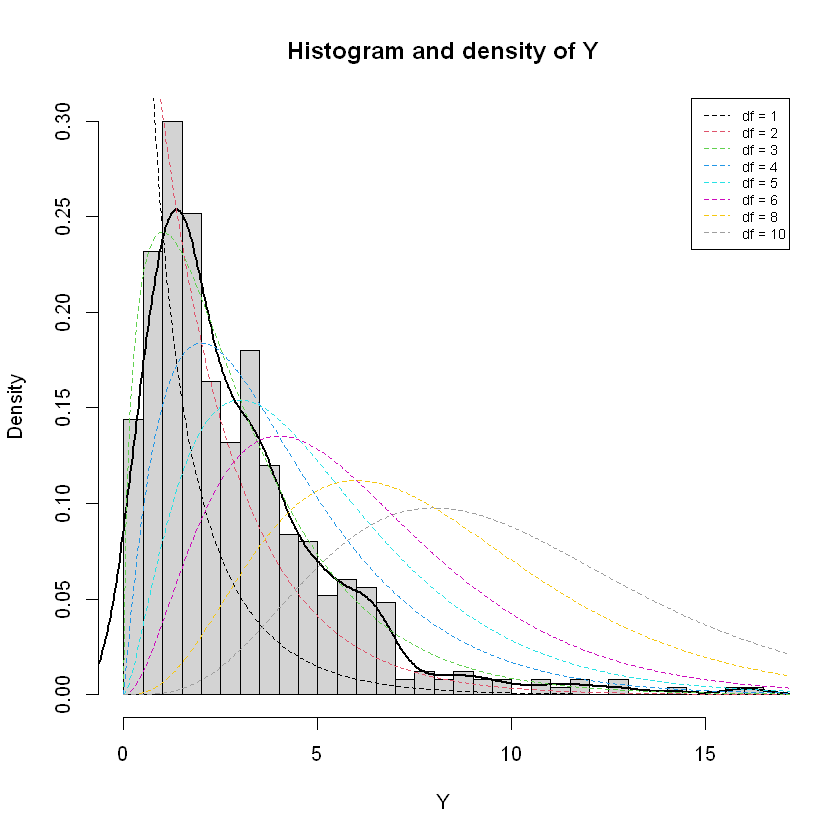

In [18]:
hw <- read.csv("hw2data.csv")
summary(hw)
Y <- hw$x 
par(bg = "white")
hist(Y,
     breaks = 30,
     freq   = FALSE,
     main   = "Histogram and density of Y",
     xlab   = "Y")

lines(density(Y), lwd = 2)

## Overlay chi-square densities for various df
x_grid <- seq(0, max(Y) * 1.1, length.out = 500)

dfs <- c(1, 2, 3, 4, 5, 6, 8, 10)  # chosen dfs

cols <- 1:length(dfs)

for (i in seq_along(dfs)) {
  lines(x_grid, dchisq(x_grid, df = dfs[i]), col = cols[i], lty = 2)
}

legend("topright",
       legend = paste0("df = ", dfs),
       col    = cols,
       lty    = 2,
       cex    = 0.7)


Based solely on graphical inspection of the histogram, kernel density, and theoretical overlays, the **preliminary estimate of the degrees of freedom is**:

$d \approx 3$

This graphical estimate will be formally tested using GMM in part (c).


## (b) Sample moment conditions based on the chi-squared distribution

For a chi-squared random variable $Y \sim \chi^2(d)$, the theoretical first two moments are:

$\mathbb{E}(Y) = d, \qquad \mathrm{Var}(Y) = 2d$

1. **Mean moment condition**
   $   g_1(d) = \bar{Y} - d = 0.$

2. **Variance moment condition**
   $   g_2(d) = s_Y^2 - 2d = 0.$

These two sample moment conditions form an overidentified GMM system for a single parameter $d$.  
They will be used in part (c) to estimate the degrees of freedom via GMM with identity and optimal weighting matrices.

In [19]:
Y_bar  <- mean(Y)
Y_var  <- mean( (Y - Y_bar)^2 )  

Y_bar
Y_var



chi2_moments <- function(theta, x) {
  d    <- as.numeric(theta[1])
  Yvec <- x

  Y_bar  <- mean(Yvec)
  Y_var  <- mean( (Yvec - Y_bar)^2 )

  g1 <- Y_bar - d        
  g2 <- Y_var - 2 * d     

  n <- length(Yvec)
  cbind(rep(g1, n), rep(g2, n))
}

[1] 2.8927

[1] 5.912142

## (c) GMM estimation of the degrees of freedom $d$


1. **Identity weighting matrix** (baseline one-step GMM)  
2. **Optimal weighting matrix** (efficient two-step GMM)

Results below:

---

### **One-step GMM (identity weighting)**
 
We *do not reject* the overidentifying restrictions.  
The moment conditions are jointly consistent with the data under identity weighting.

---

### **Two-step GMM (optimal weighting)**
  
Again, we *do not reject* the overidentifying restrictions.  
The optimal GMM weighting improves efficiency and yields an estimate very close to the identity GMM result.

---


- Both GMM versions produce estimates close to the graphical guess (~3).  
- Optimal GMM is more efficient (smaller standard error).  
- In both cases, the J-test fails to reject the model, confirming that the moment conditions based on the first two theoretical moments are valid.



In [ ]:
# function to debug (Used ChatGPT for help)
chi2_moments <- function(theta, x) {
  d    <- as.numeric(theta[1])
  Yvec <- x

  g1 <- Yvec       - d
  g2 <- Yvec^2     - (d^2 + 2 * d)

  cbind(g1, g2)
}


d_start <- mean(Y)

## 1) GMM with identity weighting)
gmm_id <- gmm(
  g       = chi2_moments,
  x       = Y,
  t0      = d_start,
  wmatrix = "ident",   W
  vcov    = "iid",    
  type    = "twoStep"
)

summary(gmm_id)
specTest(gmm_id)   

## 2) GMM with optimal weighting
gmm_opt <- gmm(
  g       = chi2_moments,
  x       = Y,
  t0      = coef(gmm_id),
  wmatrix = "optimal",
  vcov    = "iid",     
  type    = "twoStep"
)

summary(gmm_opt)
specTest(gmm_opt)



Warning message in (function (par, fn, gr = NULL, ..., method = c("Nelder-Mead", :
"one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly"



Call:
gmm(g = chi2_moments, x = Y, t0 = d_start, type = "twoStep", 
    wmatrix = "ident", vcov = "iid")


Method:  One step GMM with W = identity 

Coefficients:
          Estimate    Std. Error  t value     Pr(>|t|)  
Theta[1]  2.9087e+00  1.5796e-01  1.8414e+01  1.0108e-75

J-Test: degrees of freedom is 1 
                J-test   P-value
Test E(g)=0:    0.13241  0.71594

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  36 
Gradian eval. =  NA 


 ##  J-Test: degrees of freedom is 1  ## 

                J-test   P-value
Test E(g)=0:    0.13241  0.71594


Warning message in (function (par, fn, gr = NULL, ..., method = c("Nelder-Mead", :
"one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly"
Warning message in (function (par, fn, gr = NULL, ..., method = c("Nelder-Mead", :
"one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly"



Call:
gmm(g = chi2_moments, x = Y, t0 = coef(gmm_id), type = "twoStep", 
    wmatrix = "optimal", vcov = "iid")


Method:  twoStep 

Coefficients:
          Estimate     Std. Error   t value      Pr(>|t|)   
Theta[1]   2.8810e+00   9.4379e-02   3.0526e+01  1.1931e-204

J-Test: degrees of freedom is 1 
                J-test    P-value 
Test E(g)=0:    0.047181  0.828044

Initial values of the coefficients
Theta[1] 
2.908684 

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  32 
Gradian eval. =  NA 


 ##  J-Test: degrees of freedom is 1  ## 

                J-test    P-value 
Test E(g)=0:    0.047181  0.828044


### (d) 

Comparison 

All three approaches — manual delta method, deltamethod(), and bootstrap — deliver closely aligned variance estimates for $\Phi$. The two delta-method results match almost exactly, confirming correct analytical derivation, while the bootstrap results converge toward the same value, with the 10,000-replication version being the most stable. Overall, the methods are consistent and support the robustness of the estimated variance of $\Phi$.


In [ ]:
beta_hat
V_beta


beta1_hat <- beta_hat["(Intercept)"]
beta2_hat <- beta_hat["X"]

Phi_hat <- beta1_hat^2 - exp(beta2_hat^2)
Phi_hat



grad_Phi <- c(
  2 * beta1_hat,
  -2 * beta2_hat * exp(beta2_hat^2)
)

grad_Phi


Var_Phi_delta_hand <- as.numeric(t(grad_Phi) %*% V_beta %*% grad_Phi)
Var_Phi_delta_hand



Phi_se_delta <- deltamethod(
  ~ x1^2 - exp(x2^2),
  mean = c(beta1_hat, beta2_hat),
  cov  = V_beta
)

Phi_se_delta
Var_Phi_delta_msm <- Phi_se_delta^2
Var_Phi_delta_msm



Phi_from_sample <- function(Y_sample, X_sample) {
  fit <- lm(Y_sample ~ X_sample)
  b   <- coef(fit)
  b1  <- b[1]
  b2  <- b[2]
  b1^2 - exp(b2^2)
}

boot_Phi <- function(B) {
  n <- length(Y)
  Phi_boot <- numeric(B)

  for (b in seq_len(B)) {
    idx <- sample.int(n, size = n, replace = TRUE)
    Y_b <- Y[idx]
    X_b <- X[idx]
    Phi_boot[b] <- Phi_from_sample(Y_b, X_b)
  }

  list(
    Phi_boot = Phi_boot,
    Var      = var(Phi_boot),
    Mean     = mean(Phi_boot)
  )
}


set.seed(123)
boot_1000 <- boot_Phi(B = 1000)



boot_10000 <- boot_Phi(B = 10000)


#comaprison

cat("Phi_hat:", Phi_hat, "\n")
cat("Var(Phi) – delta method (hand):", Var_Phi_delta_hand, "\n")
cat("Var(Phi) – delta method (msm::deltamethod):", Var_Phi_delta_msm, "\n")
cat("Var(Phi) – bootstrap B=1000:", boot_1000$Var, "\n")
cat("Var(Phi) – bootstrap B=10000:", boot_10000$Var, "\n")


(Intercept)           X 
 2.87170516  0.05282716

,(Intercept),X
(Intercept),0.02042141,-0.02151603
X,-0.02151603,0.05413946


(Intercept) 
   7.243896

(Intercept)           X 
  5.7434103  -0.1059496

[1] 0.7004296

[1] 0.8369167

[1] 0.7004296

Phi_hat: 7.243896 
Var(Phi) – delta method (hand): 0.7004296 
Var(Phi) – delta method (msm::deltamethod): 0.7004296 
Var(Phi) – bootstrap B=1000: 0.6743501 
Var(Phi) – bootstrap B=10000: 0.6856812 
